In the previous router, we invoked the model and, if it chose to call a tool, we returned a ToolMessage to the user.

But, what if we simply pass that ToolMessage back to the model?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind ReAct, a general agent architecture.

act - let the model call specific tools
observe - pass the tool output back to the model
reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

In [2]:
from google.colab import userdata
GROQ_API_KEY=userdata.get('GROQ_API_KEY')
OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')
os.environ["GROQ_API_KEY"]=GROQ_API_KEY
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY


In [3]:
!pip install langchain_openai langchain_core langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 18.3 MB/s eta 0:00:00


In [4]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[add,multiply,divide]

llm=ChatOpenAI(model="gpt-4o")

llm_with_tools=llm.bind_tools(tools,parallel_tool_calls=False)

In [5]:
from langgraph.graph import MessagesState

In [6]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [7]:
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

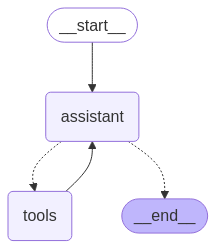

In [8]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display


builder=StateGraph(MessagesState)

## Define the node
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

## Define the edges

builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools","assistant")

react_graph=builder.compile()

# Show
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [9]:
messages = [HumanMessage(content="Add 10 and 14. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [10]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 10 and 14. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_RFdFiIGbuQNvujjUeoGbOzxI)
 Call ID: call_RFdFiIGbuQNvujjUeoGbOzxI
  Args:
    a: 10
    b: 14
================================= Tool Message =================================
Name: add

24
================================== Ai Message ==================================
Tool Calls:
  multiply (call_4QSAu3HtoQMR63mzTSL2nj07)
 Call ID: call_4QSAu3HtoQMR63mzTSL2nj07
  Args:
    a: 24
    b: 2
================================= Tool Message =================================
Name: multiply

48
================================== Ai Message ==================================
Tool Calls:
  divide (call_EWkjjpjZIoO7CT5IN04fIydc)
 Call ID: call_EWkjjpjZIoO7CT5IN04fIydc
  Args:
    a: 48
    b: 5
================================= Tool Message =========

### Agents Memory

In [11]:
messages = [HumanMessage(content="Add 14 and 15.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 14 and 15.
================================== Ai Message ==================================
Tool Calls:
  add (call_LHNVtj9bfzTAoL7VQRJ9OYgT)
 Call ID: call_LHNVtj9bfzTAoL7VQRJ9OYgT
  Args:
    a: 14
    b: 15
================================= Tool Message =================================
Name: add

29
================================== Ai Message ==================================

14 plus 15 equals 29.


In [12]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

Could you please provide the number you'd like to multiply by 2?


## MEmeory In Agents Using MemorySaver

In [13]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

react_graph=builder.compile(checkpointer=memory)

In [14]:
config={"configurable":{"thread_id":"1"}}
# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_xrho4WstI4cKRtuA8DoHzAxC)
 Call ID: call_xrho4WstI4cKRtuA8DoHzAxC
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [15]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_xrho4WstI4cKRtuA8DoHzAxC)
 Call ID: call_xrho4WstI4cKRtuA8DoHzAxC
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_YFkmHZgkrfqUDioRWITwQd9J)
 Call ID: call_YFkmHZgkrfqUDioRWITwQd9J
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

Multiplying 7 by 2 gi

In [16]:
config1={"configurable":{"thread_id":"2"}}
# Specify an input
messages = [HumanMessage(content="Add 13 and 14.")]

# Run
messages = react_graph.invoke({"messages": messages},config1)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Add 13 and 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_YCEyvbBNVDJ9Cswp9KaYgopE)
 Call ID: call_YCEyvbBNVDJ9Cswp9KaYgopE
  Args:
    a: 13
    b: 14
================================= Tool Message =================================
Name: add

27
================================== Ai Message ==================================

The sum of 13 and 14 is 27.


In [17]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages}, config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 13 and 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_YCEyvbBNVDJ9Cswp9KaYgopE)
 Call ID: call_YCEyvbBNVDJ9Cswp9KaYgopE
  Args:
    a: 13
    b: 14
================================= Tool Message =================================
Name: add

27
================================== Ai Message ==================================

The sum of 13 and 14 is 27.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ru9tT0z7IwppB9EtEJrIuvg8)
 Call ID: call_ru9tT0z7IwppB9EtEJrIuvg8
  Args:
    a: 27
    b: 2
================================= Tool Message =================================
Name: multiply

54
================================== Ai Message ==================================

Multiplying 